In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = False

In [1]:
filter_mode = 'non_linear'

In [3]:
saccade_tables_39E01 = h5py.File('detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('detected_saccades_nl_22H05.hdf5','r')


lw_natural_22H05 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_22H05['Ph0'])* 
                      np.array(saccade_tables_22H05['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['lwing_mean'])[:,None])
    
rw_natural_22H05 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_22H05['Ph1'])* 
                      np.array(saccade_tables_22H05['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['rwing_mean'])[:,None])
    
lmr_natural_22H05 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_22H05['Ph2'])* 
                      np.array(saccade_tables_22H05['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_22H05['lmr_mean'])[:,None])
    

lw_natural_39E01 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_39E01['Ph0'])* 
                      np.array(saccade_tables_39E01['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['lwing_mean'])[:,None])
    
rw_natural_39E01 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_39E01['Ph1'])* 
                      np.array(saccade_tables_39E01['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['rwing_mean'])[:,None])
    
lmr_natural_39E01 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_39E01['Ph2'])* 
                      np.array(saccade_tables_39E01['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_39E01['lmr_mean'])[:,None])

In [4]:
#sort_sig = saccade_tables['filtered'][:,20]
sort_sig_22H05 = np.mean(rw_natural_22H05[:,49:51],axis = 1) - np.mean(rw_natural_22H05[:,:30],axis = 1)
sort_sig_39E01 = np.mean(rw_natural_39E01[:,49:51],axis = 1) - np.mean(rw_natural_39E01[:,:30],axis = 1)

In [5]:
#sort_sig = saccade_tables['filtered'][:,20]
#sort_sig_22H05 = np.mean(saccade_tables_22H05['Ph1'][:,49:51],axis = 1) - np.mean(saccade_tables_22H05['Ph1'][:,:30],axis = 1)
#sort_sig_39E01 = np.mean(saccade_tables_39E01['Ph1'][:,49:51],axis = 1) - np.mean(saccade_tables_39E01['Ph1'][:,:30],axis = 1)

In [6]:
sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [7]:
#plb.imshow(np.array(saccade_tables['filtered'])[sort_idx,:],aspect='auto',vmin = -4,vmax = 4)

In [8]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];

In [9]:
sorted_saccades_22H05.update({'lw_natural':lw_natural_22H05[sort_idx_22H05]})
sorted_saccades_22H05.update({'rw_natural':rw_natural_22H05[sort_idx_22H05]})
sorted_saccades_22H05.update({'lmr_natural':lmr_natural_22H05[sort_idx_22H05]})

sorted_saccades_39E01.update({'lw_natural':lw_natural_39E01[sort_idx_39E01]})
sorted_saccades_39E01.update({'rw_natural':rw_natural_39E01[sort_idx_39E01]})
sorted_saccades_39E01.update({'lmr_natural':lmr_natural_39E01[sort_idx_39E01]})

### first look at the saccade triggered averages - broken into desciles according to response magnitude

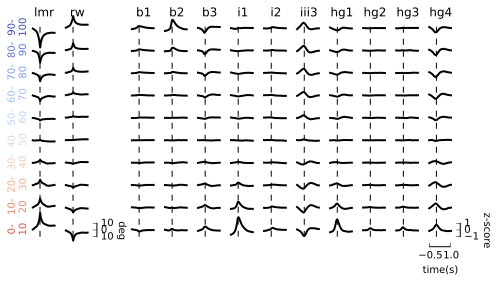

In [135]:
#signals to plot
trace_keys = ['Ph2','Ph1','','b1','b2','b3','i1','i2','iii3','hg1','hg2','hg3','hg4']
#break up the saccade responses by desciles
quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_quantile_ca(col,row):
    """plot function for saccade quantile plots"""
    if col == 2:
        return
    if col<8:
        sorted_saccades = sorted_saccades_22H05
        quantile_ranges = quantile_ranges_22H05
    else:
        sorted_saccades = sorted_saccades_39E01
        quantile_ranges = quantile_ranges_39E01

    range_start = quantile_ranges[row+1]
    range_stop = quantile_ranges[row]
    if col == 0:
        data_chunk = np.array(sorted_saccades['lmr_natural'][range_start:range_stop,:])
        data_chunk -= np.mean(data_chunk[:,:30],axis = 1)[:,np.newaxis]
        data_chunk /= 10.0
    elif col == 1:
        data_chunk = np.array(sorted_saccades['rw_natural'][range_start:range_stop,:])
        data_chunk -= np.mean(data_chunk[:,:30],axis = 1)[:,np.newaxis]
        data_chunk /= 10.0
    else:
        data_chunk = np.array(sorted_saccades[trace_keys[col]][range_start:range_stop,:])
        data_chunk -= np.mean(data_chunk,axis = 1)[:,np.newaxis]
    x = np.linspace(-50*.021,50*.021,np.shape(data_chunk)[1])[25:]
    y = np.nanmean(data_chunk,axis = 0)[25:]
    plb.plot(x, y,'k',lw = 2,clip_on = False)

rows = 10
cols = len(trace_keys)
show_spines_right = [False]*rows;show_spines_right[-1] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_right = [None]*rows;row_labels_right[-1] = 'z-score'
row_labels_left = ['%s-\n%s'%(p) for p in zip(range(90,-10,-10),range(100,0,-10))]
import copy as cp
col_labels_top =  cp.copy(trace_keys)

col_labels_top[0] = 'lmr';
col_labels_top[1] = 'rw';
col_axvlines = [0]*cols
col_axvlines[2] = None
ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_quantile_ca,
                                  figsize = (7,4.0),
                                  xbounds = (-0.5,1),
                                  ybounds = (-1,1),
                                  row_labels_left = row_labels_left,
                                  row_labels_right = row_labels_right,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  col_axvlines = col_axvlines,
                                  col_axvlines_kwargs = {'color':'k','ls':'--'},
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom)
plb.sca(ax_grid[-1][1])
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))
[x.set_visible(True) for x in plb.gca().get_yticklines()]
plb.gca().tick_params(right = True,
                      left = False,
                      labelleft = False,
                      labelright = True)
plb.yticks([-1,0,1])
plb.gca().set_yticklabels(['10','0','10'])
plb.gca().yaxis.set_label_position("right")
plb.gca().set_ylabel('deg',rotation = -90,va = 'bottom')
plb.draw()

for i,row in enumerate(ax_grid):
    plb.sca(row[0])
    c = plb.cm.coolwarm(i/10.0)
    plb.gca().yaxis.label.set_color(c)
#plb.savefig('STAs_desciles_39E01.pdf')

In [138]:
10058/(np.pi*80*2)

20.00975522022854

In [143]:
(np.pi*80*2)/60.0

8.377580409572781

In [139]:
20*1

300

In [152]:
1456*0.5

728.0

### How does the mean emerge from the single trial data - look at rasters for the two larger desciles, it appears that in some muscles saccade magnitude is reflected by changes in the probability of responses.

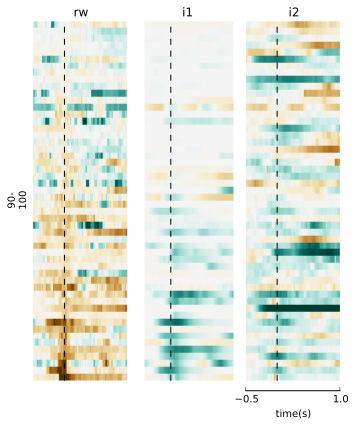

In [96]:
#trace_data = [traces_lmr,traces_rw,traces_b2,traces_b3,traces_i1]
trace_keys = ['Ph1','i1','i2']

quantile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],11).astype(int)[::-1]
quantile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],11).astype(int)[::-1]

def show_saccade_img(col,row):
    """plot function for saccade quantile plots"""
    imdx = 100
    range_start = quantile_ranges_22H05[-1]
    range_stop = quantile_ranges_22H05[-5]

    data_chunk = np.array(sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:])
    data_chunk -= np.mean(data_chunk[:,:30],axis = 1)[:,np.newaxis]
    if trace_keys[col] == 'i1':
        plb.imshow(data_chunk[::imdx,25:][::-1],
           aspect = 'auto',interpolation = 'nearest',
           vmin =-7,vmax = 7,
           extent = [-20*.021,50*.021,-4,4],
           cmap = plb.cm.BrBG)
    else:
        plb.imshow(data_chunk[::imdx,25:][::-1],
           aspect = 'auto',interpolation = 'nearest',
           vmin =-2,vmax = 2,
           extent = [-25*.021,50*.021,-4,4],
           cmap = plb.cm.BrBG)

rows = 1
cols = 3

show_spines_right = [False]*rows;show_spines_right[0] = True
show_spines_bottom = [False]*cols;show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'time(s)'
row_labels_left = ['%s-\n%s'%(p) for p in [(90,100),(70,80),(20,30),(0,10)]]
col_labels_top = ['rw','i1','i2']

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = show_saccade_img,
                                  figsize = (5.0,6.0),
                                  xbounds = (-.5,1),
                                  ybounds = (-4,4),
                                  row_labels_left = row_labels_left,
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  show_spines_right = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_bottom = show_spines_bottom)
[ax.set_zorder(np.inf) for ax in col_epoch_panels]
#plb.show()
plb.savefig('STAs_extrema_rasters_22H05.pdf')

### to quantify this effect I made histograms of the response magnitude this time broken down in 5 percentile brackets

In [97]:
demo_mode = False

In [98]:
if not(demo_mode):
    signals_to_search = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

    percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
    bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])
    bw_search = list()

    from sklearn.neighbors import KernelDensity
    from sklearn.grid_search import GridSearchCV

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)

    for bracket in range(6):
        range_start,range_stop = top30_percentile_brackets[bracket]
        for sig in signals_to_search:
            print sig
            data_chunk = np.array(sorted_saccades[sig][range_start:range_stop,:])
            X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
            grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, 1.0, 30)},
                        cv=20) # 20-fold cross-validation
            grid.fit(X)
            bw =  grid.best_params_['bandwidth']
            bw_search.append(bw)
    bandwidth = np.mean(bw_search)        
    print np.mean(bw_search)
else:
    percentile_ranges = np.linspace(0,np.shape(sorted_saccades['Ph2'])[0],100).astype(int)[::-1]
    top30_percentile_brackets = zip(percentile_ranges[5:35:5],percentile_ranges[0:30:5])
    bottom30_percentile_brackets = zip(percentile_ranges[74:105:5],percentile_ranges[70:100:5])
    bandwidth = 0.365862068966

NameError: name 'top30_percentile_brackets' is not defined

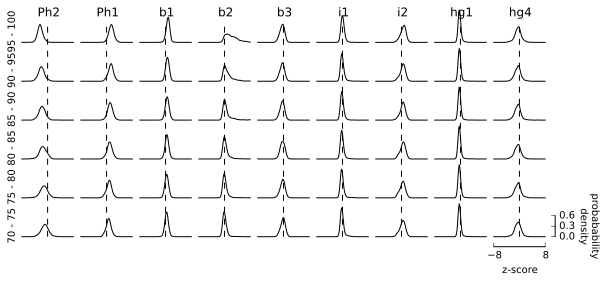

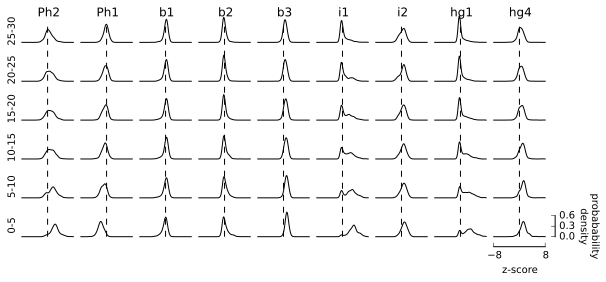

In [99]:
reload(plf)
trace_keys = ['Ph2','Ph1','b1','b2','b3','i1','i2','hg1','hg4']

bandwidth = 0.365862068966

percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[5:35:5],percentile_ranges_22H05[0:30:5])
bottom30_percentile_brackets_22H05 = zip(percentile_ranges_22H05[74:105:5],percentile_ranges_22H05[70:100:5])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
top30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[5:35:5],percentile_ranges_39E01[0:30:5])
bottom30_percentile_brackets_39E01 = zip(percentile_ranges_39E01[74:105:5],percentile_ranges_39E01[70:100:5])

def get_kde(data_chunk):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(-8, 8, 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_top30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = top30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = top30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)
    
def plot_bottom30_percentiles(col,row):
    if col < 7:
        range_start,range_stop = bottom30_percentile_brackets_22H05[row]
        data_chunk = sorted_saccades_22H05[trace_keys[col]][range_start:range_stop,:]
    else:
        range_start,range_stop = bottom30_percentile_brackets_39E01[row]
        data_chunk = sorted_saccades_39E01[trace_keys[col]][range_start:range_stop,:]
    plb.plot(*get_kde(data_chunk),color = 'k',clip_on = False)

rows = 6
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True
show_spines_bottom = [False]*cols; show_spines_bottom[-1] = True
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score'
row_labels_right = [None]*rows;row_labels_right[-1] = 'probabability \ndensity'

col_labels_top =  cp.copy(trace_keys)

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_top30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s - %s'%(p) for 
                                                     p in zip(range(70,100,5),range(75,105,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_top30_39E01.pdf')

ax_grid,row_epoch_panels,col_epoch_panels  = plf.plot_data_matrix(rows = rows,cols = cols,
                                  plot_panel_function = plot_bottom30_percentiles,
                                  figsize = (8.5,4),
                                  xbounds = (-8,8),
                                  ybounds = (0,0.6),
                                  row_labels_left = ['%s-%s'%(p) for 
                                                     p in zip(range(0,30,5),range(5,35,5))[::-1]],
                                  col_labels_bottom = col_labels_bottom,
                                  col_labels_top = col_labels_top,
                                  xtick_numbers = 2,
                                  show_spines_top = False,
                                  show_spines_left = False,
                                  col_axvlines = 0,
                                  col_axvlines_kwargs = {'ls':'--','color':'k'},
                                  show_spines_right = show_spines_right,
                                  show_spines_bottom = show_spines_bottom,
                                  row_labels_right = row_labels_right)
plb.savefig('STA_kde_bottom30_39E01.pdf')

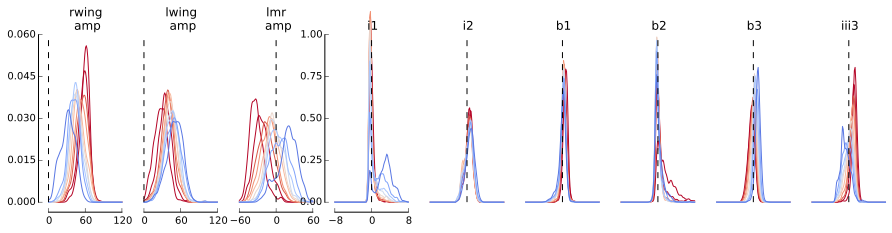

In [100]:
reload(plf)

#trace_keys = ['Ph1','Ph0','Ph2','b1','b2','b3','i1','i2','hg1','hg4']

from matplotlib.gridspec import GridSpec

trace_keys = ['Ph1','Ph0','Ph2','i1','i2','b1','b2','b3','iii3']
gs = GridSpec(2,len(trace_keys))


ax_list = list()
fig = plb.figure(figsize = (15,3))
for i in range(len(trace_keys)):
    ax_list.append(fig.add_subplot(gs[:,i]))
    
#bandwidth = 0.365862068966
bandwidth = 0.2

percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_22H05 = zip(percentile_ranges_22H05[9:110:10],percentile_ranges_22H05[0:100:10])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_39E01 = zip(percentile_ranges_39E01[9:110:10],percentile_ranges_39E01[0:100:10])

def get_kde(data_chunk,xrng = [-8,8],bandwidth = 0.2):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(xrng[0], xrng[1], 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_descile_hists(col,row):
    if row == 0:
        skey = trace_keys[col]
        if skey in ['Ph0','Ph1','Ph2']:
            xrng = [90,180]
            for range_start,range_stop in decile_brackets_22H05[::]:
                c = plb.cm.coolwarm(float(range_stop)/decile_brackets_22H05[1][-1])
                data_chunk = np.array(sorted_saccades_22H05[skey][range_start:range_stop,:])
                mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[skey]
                nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[skey]
                data_chunk *= np.array(sorted_saccades_22H05[nkey][range_start:range_stop])[:,None]
                data_chunk += np.array(sorted_saccades_22H05[mkey][range_start:range_stop])[:,None]
                data_chunk = gd.signal_plot_info[skey]['transform'](data_chunk)
                if skey in ['Ph0','Ph1']:
                    plb.plot(*get_kde(data_chunk,xrng = [0,120],bandwidth = 2.5),color = c,clip_on = False)
                else:
                    plb.plot(*get_kde(data_chunk,xrng = [-60,60],bandwidth = 2.5),color = c,clip_on = False)
            plb.gca().set_ybound(0,0.06)
            plb.yticks(np.linspace(0,0.06,3))
        elif not(skey in ['hg1','hg4']):
            for range_start,range_stop in decile_brackets_22H05[::]:
                c = plb.cm.coolwarm(float(range_stop)/decile_brackets_22H05[1][-1])
                data_chunk = sorted_saccades_22H05[skey][range_start:range_stop,:]
                plb.plot(*get_kde(data_chunk),color = c,clip_on = False)
        else:
            for range_start,range_stop in decile_brackets_39E01[::]:
                c = plb.cm.coolwarm(float(range_stop)/decile_brackets_39E01[1][-1])
                data_chunk = sorted_saccades_39E01[skey][range_start:range_stop,:]
                plb.plot(*get_kde(data_chunk),color = c,clip_on = False)

rows = 1
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True;
show_spines_left = [False]*cols; show_spines_left[0] = True;show_spines_left[3] = True; 
show_spines_bottom = [False]*cols; show_spines_bottom[0:4] = [True]*4
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score';col_labels_bottom[2] = 'saccade \n magnitude (deg)'
row_labels_left = [None]*rows;row_labels_left[0] = 'probabability \ndensity'
col_labels_top =  [gd.signal_plot_info[x]['ax_label'] for x in trace_keys]
ybounds_left = [(0,1)]*cols;ybounds_left[:3] = [(0,0.06)]*3
yticks_left = [np.linspace(0,1,3)]*cols;yticks_left[:3] = [np.linspace(0,0.06,3)]*3
xticks_bottom = [np.linspace(-8,8,3)]*cols;xticks_bottom[:2] = [np.linspace(0,120,3)]*2;
xticks_bottom[2] = np.linspace(-60,60,3);

for row in range(rows):
    for col in range(cols):
        plb.sca(ax_list[col])
        plot_descile_hists(col,row)
        plb.gca().set_ybound(ybounds_left[col])
        plb.yticks(yticks_left[col])
        plf.pull_ax_spines(bottom = show_spines_bottom[col],left = show_spines_left[col])
        plb.xticks(xticks_bottom[col])
        plb.axvline(0,**{'ls':'--','color':'k'})
        plb.gca().set_title(gd.signal_plot_info[trace_keys[col]]['ax_label'])

plb.subplots_adjust(wspace = 0.3,hspace = 0.1)        
plb.savefig('STA_kde_22H05.pdf')

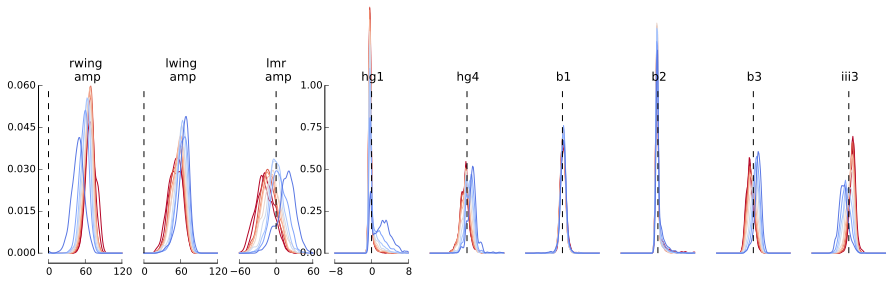

In [15]:
reload(plf)

#trace_keys = ['Ph1','Ph0','Ph2','b1','b2','b3','i1','i2','hg1','hg4']

from matplotlib.gridspec import GridSpec

trace_keys = ['Ph1','Ph0','Ph2','hg1','hg4','b1','b2','b3','iii3']
gs = GridSpec(2,len(trace_keys))


ax_list = list()
fig = plb.figure(figsize = (15,3))
for i in range(len(trace_keys)):
    ax_list.append(fig.add_subplot(gs[:,i]))
    
#bandwidth = 0.365862068966
bandwidth = 0.2

percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_22H05 = zip(percentile_ranges_22H05[9:110:10],percentile_ranges_22H05[0:100:10])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_39E01 = zip(percentile_ranges_39E01[9:110:10],percentile_ranges_39E01[0:100:10])

def get_kde(data_chunk,xrng = [-8,8],bandwidth = 0.2):
    from sklearn.neighbors import KernelDensity
    X = np.mean(data_chunk[:,49:51],axis = 1)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(xrng[0], xrng[1], 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return X_plot,np.exp(log_dens)

def plot_descile_hists(col,row):
    if row == 0:
        skey = trace_keys[col]
        if skey in ['Ph0','Ph1','Ph2']:
            xrng = [90,180]
            for range_start,range_stop in decile_brackets_39E01[::]:
                c = plb.cm.coolwarm(float(range_stop)/decile_brackets_39E01[1][-1])
                data_chunk = np.array(sorted_saccades_39E01[skey][range_start:range_stop,:])
                mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[skey]
                nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[skey]
                data_chunk *= np.array(sorted_saccades_39E01[nkey][range_start:range_stop])[:,None]
                data_chunk += np.array(sorted_saccades_39E01[mkey][range_start:range_stop])[:,None]
                data_chunk = gd.signal_plot_info[skey]['transform'](data_chunk)
                if skey in ['Ph0','Ph1']:
                    plb.plot(*get_kde(data_chunk,xrng = [0,120],bandwidth = 2.5),color = c,clip_on = False)
                else:
                    plb.plot(*get_kde(data_chunk,xrng = [-60,60],bandwidth = 2.5),color = c,clip_on = False)
        else:
            for range_start,range_stop in decile_brackets_39E01[::]:
                c = plb.cm.coolwarm(float(range_stop)/decile_brackets_39E01[1][-1])
                data_chunk = sorted_saccades_39E01[skey][range_start:range_stop,:]
                plb.plot(*get_kde(data_chunk),color = c,clip_on = False)

rows = 1
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True;
show_spines_left = [False]*cols; show_spines_left[0] = True;show_spines_left[3] = True; 
show_spines_bottom = [False]*cols; show_spines_bottom[0:4] = [True]*4
col_labels_bottom = [None]*cols;col_labels_bottom[-1] = 'z-score';col_labels_bottom[2] = 'saccade \n magnitude (deg)'
row_labels_left = [None]*rows;row_labels_left[0] = 'probabability \ndensity'
col_labels_top =  [gd.signal_plot_info[x]['ax_label'] for x in trace_keys]
ybounds_left = [(0,1)]*cols;ybounds_left[:3] = [(0,0.06)]*3
yticks_left = [np.linspace(0,1,3)]*cols;yticks_left[:3] = [np.linspace(0,0.06,3)]*3
xticks_bottom = [np.linspace(-8,8,3)]*cols;xticks_bottom[:2] = [np.linspace(0,120,3)]*2;
xticks_bottom[2] = np.linspace(-60,60,3);

for row in range(rows):
    for col in range(cols):
        plb.sca(ax_list[col])
        plot_descile_hists(col,row)
        plb.gca().set_ybound(ybounds_left[col])
        plb.yticks(yticks_left[col])
        plf.pull_ax_spines(bottom = show_spines_bottom[col],left = show_spines_left[col])
        plb.xticks(xticks_bottom[col])
        plb.axvline(0,**{'ls':'--','color':'k'})
        plb.gca().set_title(gd.signal_plot_info[trace_keys[col]]['ax_label'])

plb.subplots_adjust(wspace = 0.3,hspace = 0.1)        
plb.savefig('STA_kde_39E01.pdf')

In [109]:
range_start,range_stop = decile_brackets_22H05[-1]
#range_start_,range_stop = decile_brackets_22H05[-5]

In [110]:
def resample_ts_ci(dataset,nsamples = 100):
    synthetic_means = np.zeros([nsamples,np.shape(dataset)[1]])
    idxs = np.arange(np.shape(dataset)[0])
    for i in range(nsamples):
        synthetic_means[i,:] = np.mean(dataset[np.random.choice(idxs,size = len(idxs)),:],axis = 0)
    ub = np.nanpercentile(synthetic_means,97.5,axis = 0)
    lb = np.nanpercentile(synthetic_means,2.5,axis = 0)
    mean = np.mean(dataset,axis =0)
    return ub,lb,mean

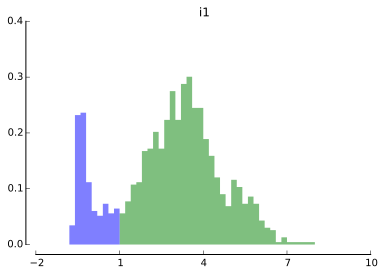

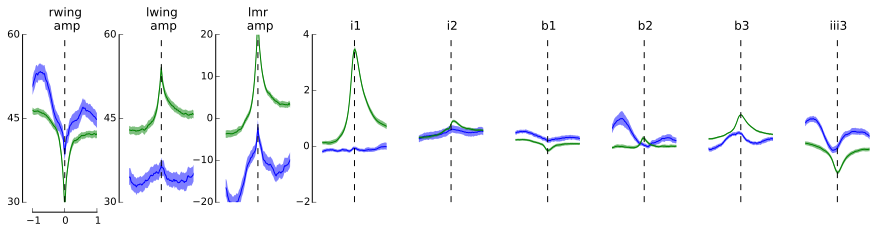

In [127]:
range_start,range_stop = decile_brackets_22H05[-1]
#range_start_,range_stop = decile_brackets_22H05[-5]
plb.figure()
idx_rng = np.arange(0,len(sorted_saccades_22H05['i1']))
range_mask = (idx_rng > range_start) & (idx_rng < range_stop)
mag_mask_i1_off = sorted_saccades_22H05['i1'][:,50] < 1.0
mag_mask_i1_on = sorted_saccades_22H05['i1'][:,50] > 1.0
i1_off = sorted_saccades_22H05['i1'][range_mask & mag_mask_i1_off][:,50]
i1_on = sorted_saccades_22H05['i1'][range_mask & mag_mask_i1_on][:,50]

plb.gca().set_xbound(-2,10)
plb.gca().set_ybound(0,0.4)

#lns = plb.hist([i1_off,i1_on],bins = np.linspace(-10,10,100),stacked = True,normed = True)

lns = plb.hist([i1_off,i1_on],bins = np.arange(-2,10,0.2),stacked = True,normed = True,
               histtype = 'stepfilled',clip_on = False,alpha = 0.5,lw = 0)

plb.gca().set_xbound(-2,10)
plb.gca().set_ybound(0,0.4)
plf.pull_ax_spines()
plb.gca().set_title('i1')
plb.savefig('top_i1_amp_dist.pdf')

from matplotlib.gridspec import GridSpec

gs = GridSpec(2,len(trace_keys))

trace_keys = ['Ph1','Ph0','Ph2','i1','i2','b1','b2','b3','iii3']

ax_list = list()
fig = plb.figure(figsize = (15,3))

ax_list.append(fig.add_subplot(gs[:,0]))
ax_list.append(fig.add_subplot(gs[:,1]))
#ax_list.append([fig.add_subplot(gs[0,2]),fig.add_subplot(gs[1,2])])

for i in range(2,len(trace_keys)):
    ax_list.append(fig.add_subplot(gs[:,i]))

def plot_parsed_stas(col,row):
    xi = (np.arange(0,100)-50)*0.021
    try:
        sig_key = trace_keys[col]
        if sig_key in ['Ph1','Ph0']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_i1_off]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_i1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')

            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_on]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_i1_on]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_i1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(30,60)
            plb.gca().set_xbound(-1,1)
            if col == 0:
                plf.pull_ax_spines(bottom = True)
                plb.gca().set_xticks(np.linspace(-1,1,3))
            else:
                plf.pull_ax_spines(bottom = False)
            plb.axvline(ls='--',color='k')
            plb.gca().set_yticks(np.linspace(30,60,3))

        
        elif sig_key in ['Ph2']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_i1_off]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_i1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b');plf.pull_ax_spines(bottom = False)
            
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_on]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_i1_on]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_i1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(-20,20)
            plb.gca().set_xbound(-1,1)
            plb.axvline(ls='--',color='k')
            plf.pull_ax_spines(bottom = False)
        else:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_off]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_i1_on]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g')
            plb.gca().set_ybound(-2,4)
            plb.gca().set_xbound(-1,1)
            if col == 3:
                plf.pull_ax_spines(bottom = False)
            else:
                plf.pull_ax_spines(bottom = False,left = False)
            plb.gca().set_yticks([-2,0,2,4])
            plb.axvline(ls='--',color='k')
    except KeyError:
        plf.kill_spines()

rows = 1
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True;
show_spines_left = [False]*rows; show_spines_left[0] = True;
show_spines_bottom = [False]*cols;show_spines_bottom[0] = True
col_labels_bottom = [None]*cols;col_labels_bottom[0] = 'time (s)'
row_labels_left = [None]*rows;row_labels_left[0] = 'amplitude (deg)'
col_axvlines = [0]*cols;col_axvlines[3] = None

col_labels_top = list()
for i,x in enumerate(trace_keys):
    try:
        col_labels_top.append(gd.signal_plot_info[x]['ax_label'])
    except KeyError:
        col_labels_top.append(x)

for row in range(rows):
    for col in range(cols):
        plot_parsed_stas(col,row)

plb.subplots_adjust(wspace = 0.5,hspace = 0.1)
for ax,title in zip(ax_list,col_labels_top):
    ax.set_title(title)
plb.savefig('top_i1_stas.pdf')

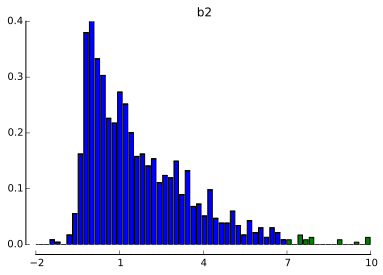

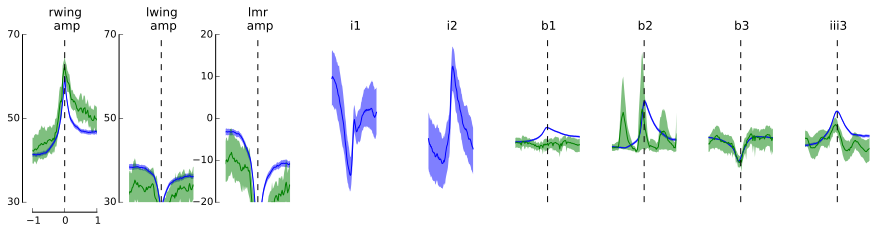

In [112]:
range_start,range_stop = decile_brackets_22H05[0]

plb.figure()
idx_rng = np.arange(0,len(sorted_saccades_22H05['b2']))
range_mask = (idx_rng > range_start) & (idx_rng < range_stop)
mag_mask_hg1_off = sorted_saccades_22H05['b2'][:,50] < 7
mag_mask_hg1_on = sorted_saccades_22H05['b2'][:,50] > 7
hg1_off = sorted_saccades_22H05['b2'][range_mask & mag_mask_hg1_off][:,50]
hg1_on = sorted_saccades_22H05['b2'][range_mask & mag_mask_hg1_on][:,50]
lns = plb.hist([hg1_off,hg1_on],bins = np.linspace(-10,10,100),stacked = True,normed = True)
plb.gca().set_xbound(-2,10)
plb.gca().set_ybound(0,0.4)
plf.pull_ax_spines()
plb.gca().set_title('b2')
plb.savefig('top_hg1_amp_dist.pdf')

from matplotlib.gridspec import GridSpec

gs = GridSpec(2,len(trace_keys))

trace_keys = ['Ph1','Ph0','Ph2','i1','i2','b1','b2','b3','iii3']

ax_list = list()
fig = plb.figure(figsize = (15,3))

ax_list.append(fig.add_subplot(gs[:,0]))
ax_list.append(fig.add_subplot(gs[:,1]))
#ax_list.append([fig.add_subplot(gs[0,2]),fig.add_subplot(gs[1,2])])

for i in range(2,len(trace_keys)):
    ax_list.append(fig.add_subplot(gs[:,i]))

def plot_parsed_stas(col,row):
    xi = (np.arange(0,100)-50)*0.021
    try:
        sig_key = trace_keys[col]
        if sig_key in ['Ph1','Ph0']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_hg1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_hg1_off]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_hg1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')

            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_hg1_on]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_hg1_on]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_hg1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(30,70)
            plb.gca().set_xbound(-1,1)
            if col == 0:
                plf.pull_ax_spines(bottom = True)
                plb.gca().set_xticks(np.linspace(-1,1,3))
            else:
                plf.pull_ax_spines(bottom = False)
            plb.axvline(ls='--',color='k')
            plb.gca().set_yticks(np.linspace(30,70,3))

        
        elif sig_key in ['Ph2']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_hg1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_hg1_off]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_hg1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b');plf.pull_ax_spines(bottom = False)
            
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_hg1_on]
            snorms = sorted_saccades_22H05[nkey][range_mask & mag_mask_hg1_on]
            smeans = sorted_saccades_22H05[mkey][range_mask & mag_mask_hg1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(-20,20)
            plb.gca().set_xbound(-1,1)
            plb.axvline(ls='--',color='k')
            plf.pull_ax_spines(bottom = False)
        else:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_22H05[sig_key][range_mask & mag_mask_hg1_off]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_on]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g')
            plb.gca().set_ybound(-2,4)
            plb.gca().set_xbound(-1,1)
            if col == 3:
                plf.pull_ax_spines(bottom = False)
            else:
                plf.pull_ax_spines(bottom = False,left = False)
            plb.gca().set_yticks([-2,0,2,4])
            plb.axvline(ls='--',color='k')
    except KeyError:
        plf.kill_spines()

rows = 1
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True;
show_spines_left = [False]*rows; show_spines_left[0] = True;
show_spines_bottom = [False]*cols;show_spines_bottom[0] = True
col_labels_bottom = [None]*cols;col_labels_bottom[0] = 'time (s)'
row_labels_left = [None]*rows;row_labels_left[0] = 'amplitude (deg)'
col_axvlines = [0]*cols;col_axvlines[3] = None

col_labels_top = list()
for i,x in enumerate(trace_keys):
    try:
        col_labels_top.append(gd.signal_plot_info[x]['ax_label'])
    except KeyError:
        col_labels_top.append(x)

for row in range(rows):
    for col in range(cols):
        plot_parsed_stas(col,row)

plb.subplots_adjust(wspace = 0.5,hspace = 0.1)
for ax,title in zip(ax_list,col_labels_top):
    ax.set_title(title)
plb.savefig('top_hg1_stas.pdf')

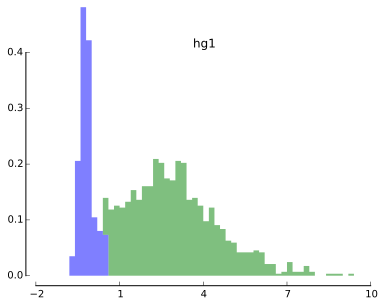

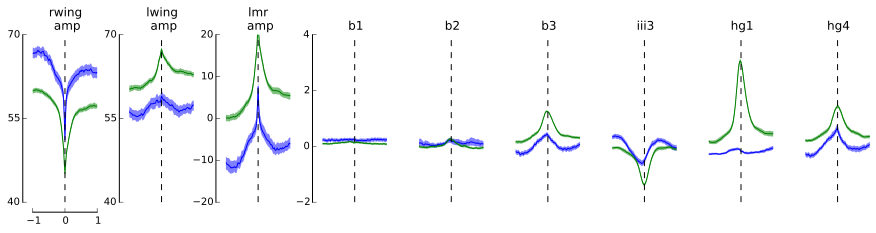

In [126]:
range_start,range_stop = decile_brackets_39E01[-1]
#range_start_,range_stop = decile_brackets_22H05[-5]
plb.figure()
idx_rng = np.arange(0,len(sorted_saccades_39E01['hg1']))
range_mask = (idx_rng > range_start) & (idx_rng < range_stop)
mag_mask_hg1_off = sorted_saccades_39E01['hg1'][:,50] < 0.5
mag_mask_hg1_on = sorted_saccades_39E01['hg1'][:,50] > 0.5
hg1_off = sorted_saccades_39E01['hg1'][range_mask & mag_mask_hg1_off][:,50]
hg1_on = sorted_saccades_39E01['hg1'][range_mask & mag_mask_hg1_on][:,50]
lns = plb.hist([hg1_off,hg1_on],bins = np.arange(-2,10,0.2),stacked = True,normed = True,
               histtype = 'stepfilled',clip_on = False,alpha = 0.5,lw = 0)
plb.gca().set_xbound(-2,10)
plb.gca().set_ybound(0,0.4)
plf.pull_ax_spines()
plb.gca().set_title('hg1')
plb.savefig('top_hg1_amp_dist.pdf')

from matplotlib.gridspec import GridSpec

gs = GridSpec(2,len(trace_keys))

trace_keys = ['Ph1','Ph0','Ph2','b1','b2','b3','iii3','hg1','hg4']

ax_list = list()
fig = plb.figure(figsize = (15,3))

ax_list.append(fig.add_subplot(gs[:,0]))
ax_list.append(fig.add_subplot(gs[:,1]))
#ax_list.append([fig.add_subplot(gs[0,2]),fig.add_subplot(gs[1,2])])

for i in range(2,len(trace_keys)):
    ax_list.append(fig.add_subplot(gs[:,i]))

def plot_parsed_stas(col,row):
    xi = (np.arange(0,100)-50)*0.021
    try:
        sig_key = trace_keys[col]
        if sig_key in ['Ph1','Ph0']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_39E01[nkey][range_mask & mag_mask_hg1_off]
            smeans = sorted_saccades_39E01[mkey][range_mask & mag_mask_hg1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')

            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_on]
            snorms = sorted_saccades_39E01[nkey][range_mask & mag_mask_hg1_on]
            smeans = sorted_saccades_39E01[mkey][range_mask & mag_mask_hg1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(40,70)
            plb.gca().set_xbound(-1,1)
            if col == 0:
                plf.pull_ax_spines(bottom = True)
                plb.gca().set_xticks(np.linspace(-1,1,3))
            else:
                plf.pull_ax_spines(bottom = False)
            plb.axvline(ls='--',color='k')
            plb.gca().set_yticks(np.linspace(40,70,3))

        
        elif sig_key in ['Ph2']:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_off]
            nkey = {'Ph0':'lwing_norm','Ph1':'rwing_norm','Ph2':'lmr_norms'}[sig_key]
            mkey = {'Ph0':'lwing_mean','Ph1':'rwing_mean','Ph2':'lmr_mean'}[sig_key]
            snorms = sorted_saccades_39E01[nkey][range_mask & mag_mask_hg1_off]
            smeans = sorted_saccades_39E01[mkey][range_mask & mag_mask_hg1_off]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b');plf.pull_ax_spines(bottom = False)
            
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_on]
            snorms = sorted_saccades_39E01[nkey][range_mask & mag_mask_hg1_on]
            smeans = sorted_saccades_39E01[mkey][range_mask & mag_mask_hg1_on]
            dataset *= snorms[:,None]
            dataset += smeans[:,None]
            dataset = gd.signal_plot_info[sig_key]['transform'](dataset)

            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g');
            plb.gca().set_ybound(-20,20)
            plb.gca().set_xbound(-1,1)
            plb.axvline(ls='--',color='k')
            plf.pull_ax_spines(bottom = False)
        else:
            plb.sca(ax_list[col])
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_off]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none')
            plb.plot(xi,mn,color = 'b')
            dataset = sorted_saccades_39E01[sig_key][range_mask & mag_mask_hg1_on]
            ub,lb,mn = resample_ts_ci(dataset)
            plb.fill_between(xi,ub,lb,alpha = 0.5,edgecolor = 'none',facecolor = 'g')
            plb.plot(xi,mn,color = 'g')
            plb.gca().set_ybound(-2,4)
            plb.gca().set_xbound(-1,1)
            if col == 3:
                plf.pull_ax_spines(bottom = False)
            else:
                plf.pull_ax_spines(bottom = False,left = False)
            plb.gca().set_yticks([-2,0,2,4])
            plb.axvline(ls='--',color='k')
    except KeyError:
        plf.kill_spines()

rows = 1
cols = len(trace_keys)
show_spines_right = [False]*rows; show_spines_right[-1] = True;
show_spines_left = [False]*rows; show_spines_left[0] = True;
show_spines_bottom = [False]*cols;show_spines_bottom[0] = True
col_labels_bottom = [None]*cols;col_labels_bottom[0] = 'time (s)'
row_labels_left = [None]*rows;row_labels_left[0] = 'amplitude (deg)'
col_axvlines = [0]*cols;col_axvlines[3] = None

col_labels_top = list()
for i,x in enumerate(trace_keys):
    try:
        col_labels_top.append(gd.signal_plot_info[x]['ax_label'])
    except KeyError:
        col_labels_top.append(x)

for row in range(rows):
    for col in range(cols):
        plot_parsed_stas(col,row)

plb.subplots_adjust(wspace = 0.5,hspace = 0.1)
for ax,title in zip(ax_list,col_labels_top):
    ax.set_title(title)
plb.savefig('top_hg1_stas.pdf')

In [130]:
xi = gd.get_xio('yaw_left')
stim_mask = (xi[sorted_saccades_22H05['peak']] > 0.0) & (xi[sorted_saccades_22H05['peak']] < 3.0)
bsln_mask = (xi[sorted_saccades_22H05['peak']] > -3.0) & (xi[sorted_saccades_22H05['peak']] < 0.0)
yl_trial_mask = sorted_saccades_22H05['trial_names']  == 'yaw_left'
yr_trial_mask = sorted_saccades_22H05['trial_names']  == 'yaw_right'
td_trial_mask = sorted_saccades_22H05['trial_names']  == 'ascending'
tu_trial_mask = sorted_saccades_22H05['trial_names']  == 'descending'

2015

In [61]:
set(sorted_saccades_22H05['trial_names'])

{'ascending',
 'descending',
 'progressive',
 'regressive',
 'yaw_left',
 'yaw_right'}

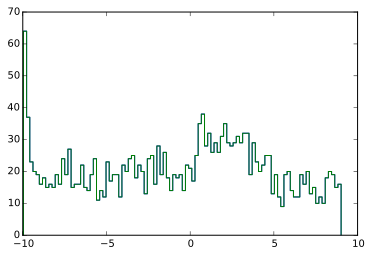

In [110]:
#plb.plot(xi[sorted_saccades_22H05['peak']][yr_trial_mask],np.random.random(np.sum(yr_trial_mask)),'o')
#fig = plb.figure(figsize = (10,10))
lns = plb.hist(xi[sorted_saccades_22H05['peak']][td_trial_mask],bins = 100,histtype='step')
lns = plb.hist(xi[sorted_saccades_22H05['peak']][td_trial_mask],bins = 100,histtype='step')

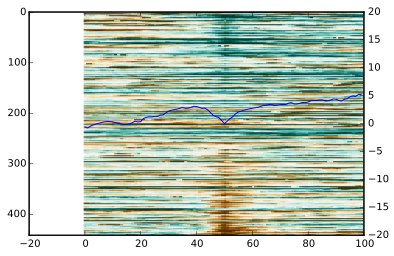

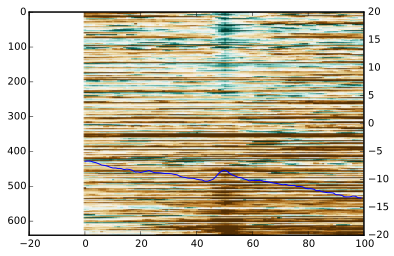

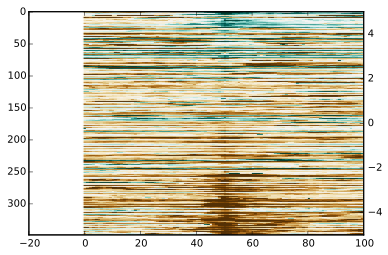

In [131]:
dtmtrx = np.array(sorted_saccades_22H05['lmr_natural'])[yl_trial_mask & stim_mask]
#dtmtrx = np.array(sorted_saccades_22H05['i2'])[yl_trial_mask & stim_mask]
#dtmtrx -= np.nanmean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -30,vmax = 30)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-20,20)
plb.figure()

dtmtrx = np.array(sorted_saccades_22H05['lmr_natural'])[yr_trial_mask & stim_mask]
#dtmtrx = np.array(sorted_saccades_22H05['i2'])[yl_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -30,vmax = 30)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-20,20)
plb.figure()

dtmtrx = np.array(sorted_saccades_22H05['lmr_natural'])[tu_trial_mask & bsln_mask]
#dtmtrx = np.array(sorted_saccades_22H05['i2'])[yl_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -30,vmax = 30)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-5,5)

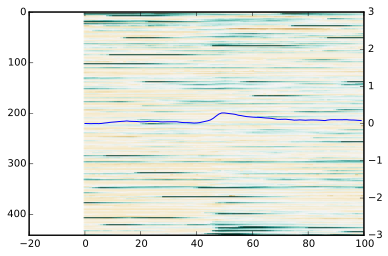

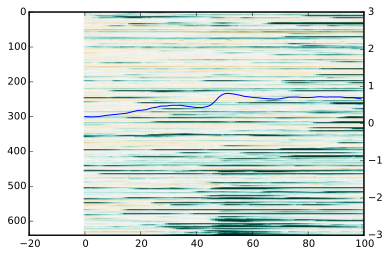

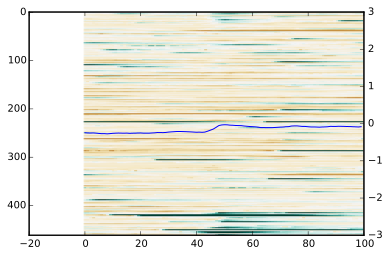

In [132]:
#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yl_trial_mask & stim_mask]
dtmtrx = np.array(sorted_saccades_22H05['b2'])[yl_trial_mask & stim_mask]
#dtmtrx -= np.nanmean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)
plb.figure()

#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yr_trial_mask & stim_mask]
dtmtrx = np.array(sorted_saccades_22H05['b2'])[yr_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)
plb.figure()

#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yr_trial_mask & bsln_mask]
dtmtrx = np.array(sorted_saccades_22H05['b2'])[td_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)

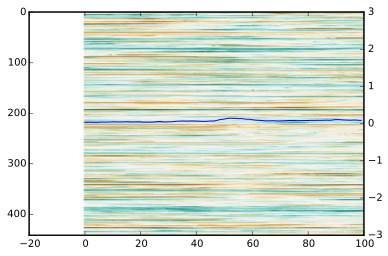

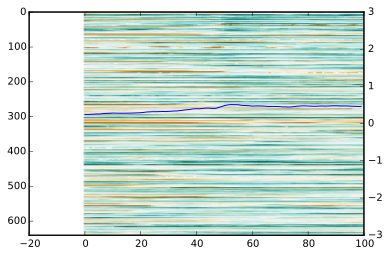

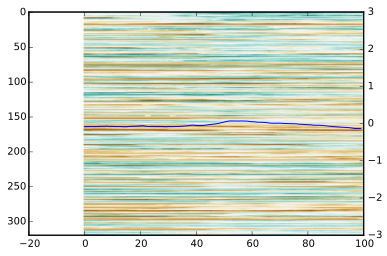

In [133]:
#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yl_trial_mask & stim_mask]
dtmtrx = np.array(sorted_saccades_22H05['i2'])[yl_trial_mask & stim_mask]
#dtmtrx -= np.nanmean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)
plb.figure()

#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yr_trial_mask & stim_mask]
dtmtrx = np.array(sorted_saccades_22H05['i2'])[yr_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)
plb.figure()

#dtmtrx = np.array(sorted_saccades_22H05['lw_natural'])[yr_trial_mask & bsln_mask]
dtmtrx = np.array(sorted_saccades_22H05['i2'])[tu_trial_mask & stim_mask]
#dtmtrx -= np.mean(dtmtrx[:,:30],axis = 1)[:,None]
plb.imshow(dtmtrx,vmin = -3,vmax = 3)
plb.twinx()
plb.plot(np.mean(dtmtrx,axis = 0))
plb.gca().set_ybound(-3,3)

In [68]:
total_time = xi[-1]-xi[0]
bin_time = total_time/100